## TUF Region Clustering

- Region: [1000000-20000000]
- Window size: 100
- Sam configuration

```
"sam_read_config":{
    "max_depth":1000,
    "ignore_orphans":false,
    "truncate":true,
    "quality_threshold":20,
    "add_indels":true
  },
```

```skleanr

In [2]:
import sys
sys.path.append("../")

In [3]:
from itertools import cycle, islice

In [4]:
from sklearn import mixture
from sklearn import metrics
from sklearn.cluster import KMeans

In [5]:
import numpy as np
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [6]:
sns.set(color_codes=True)

In [7]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [8]:
wga_mean_file = "/home/david/Desktop/wga_windows_mean_0_GMM.txt"
no_wga_mean_file = "/home/david/Desktop/no_wga_windows_mean_0_GMM.txt"
gc_file = "/home/david/Desktop/windows_gc_0_GMM.txt"

In [9]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)
gc = load_data_file(filename=gc_file)

In [10]:
assert len(wga_mu) == len(no_wga_mu)
assert len(gc) == len(wga_mu)

In [11]:
print("Size of WGA sample {0}".format(len(wga_mu)))
print("WGA max: {0}".format(max(wga_mu)))
print("WGA min: {0}".format(min(wga_mu)))
print("WGA mean: {0}".format(np.mean(wga_mu)))
print("WGA var: {0}".format(np.var(wga_mu)))

Size of WGA sample 185329
WGA max: 52.13
WGA min: 0.0
WGA mean: 18.00699696215919
WGA var: 100.56252905243802


In [12]:
#sns.distplot(wga_mu, bins=35, kde=False, rug=True)
#plt.xlabel("WGA means")
#plt.show()

In [13]:
print("NO-WGA size {0}".format(len(no_wga_mu)))
print("NO-WGA max: {0}".format(max(no_wga_mu)))
print("NO-WGA min: {0}".format(min(no_wga_mu)))
print("NO-WGA mean: {0}".format(np.mean(no_wga_mu)))
print("NO-WGA var: {0}".format(np.var(no_wga_mu)))

NO-WGA size 185329
NO-WGA max: 35.17
NO-WGA min: 0.0
NO-WGA mean: 16.24269504502803
NO-WGA var: 21.10931204078077


In [14]:
#sns.distplot(no_wga_mu, bins=35, kde=False, rug=True)
#plt.xlabel("NO-WGA means")
#plt.show()

In [16]:
X = np.stack((no_wga_mu, wga_mu), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

Covariance matrix: 
 [[ 21.10942594  11.99723456]
 [ 11.99723456 100.56307167]]
 Eigenvalues: 
 [ 19.33740434 102.33509327]
 Eigenvectors: 
 [[-0.98926728  0.14611726]
 [ 0.14611726  0.98926728]]


In [19]:
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
print("Pearson correlation: ", pearson)

Pearson correlation:  0.260389623275603


In [17]:
ratio = []
for no_wga, wga  in zip(no_wga_mu, wga_mu):
    ratio.append((wga + 1)/(no_wga + 1))
    
ratio = np.array(ratio)
print("NaN in ratio: ", np.any(np.isnan(ratio)))
print("Max ratio: ", max(ratio))
print("Min ratio: ", min(ratio))
X = np.stack((no_wga_mu, wga_mu, ratio), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

NaN in ratio:  False
Max ratio:  10.748587570621469
Min ratio:  0.027878449958182328
Covariance matrix: 
 [[ 21.10942594  11.99723456  -0.66658645]
 [ 11.99723456 100.56307167   5.32225399]
 [ -0.66658645   5.32225399   0.39999826]]
 Eigenvalues: 
 [3.19770266e-02 1.94440473e+01 1.02596472e+02]
 Eigenvectors: 
 [[ 0.06599407  0.98721833 -0.14506811]
 [-0.06060407 -0.14115098 -0.98813134]
 [ 0.99597788 -0.07400252 -0.05051432]]


Text(0.5, 0, 'Ratio')

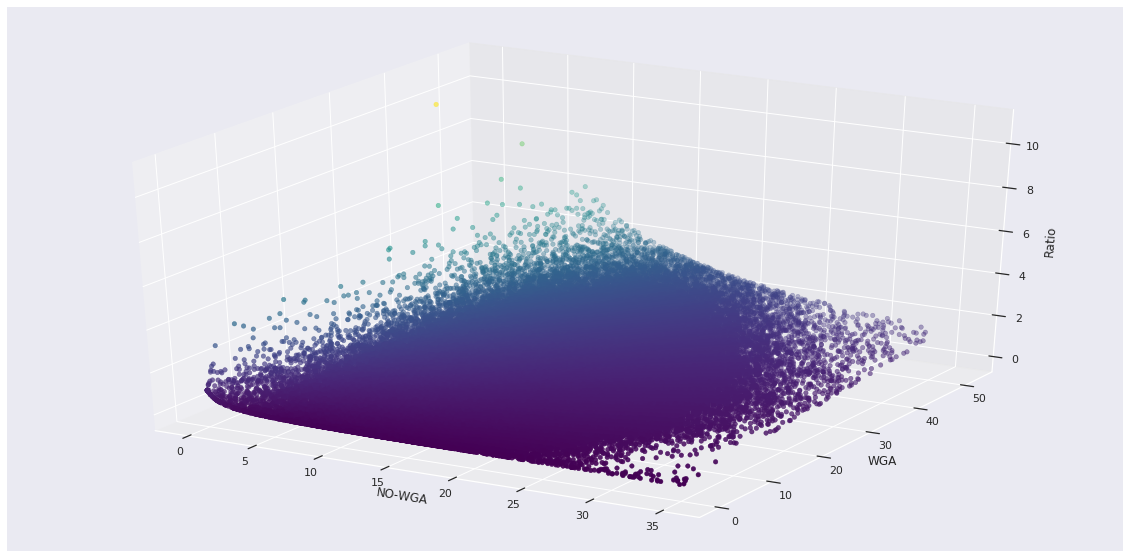

In [18]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(no_wga_mu, wga_mu, ratio, c=ratio, cmap='viridis', linewidth=0.5);
ax.set_xlabel('NO-WGA')
ax.set_ylabel('WGA')
ax.set_zlabel('Ratio')

In [20]:
print("GC size {0}".format(len(gc)))
print("GC max: {0}".format(max(gc)))
print("GC min: {0}".format(min(gc)))
print("GC mean: {0}".format(np.mean(gc)))
print("GC var: {0}".format(np.var(gc)))

GC size 185329
GC max: 0.93
GC min: 0.0
GC mean: 0.49600305402824174
GC var: 0.01198275802638238


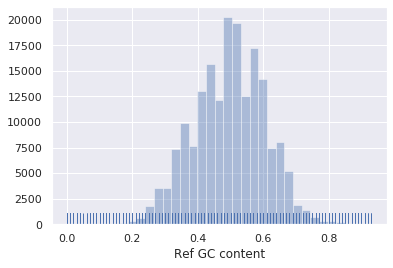

In [21]:
sns.distplot(gc, bins=35, kde=False, rug=True)
plt.xlabel("Ref GC content")
plt.show()

In [22]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [23]:
def kmeans_clustering(clusters, data, no_wga_mu, wga_mu):
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        kmeans = KMeans(n_clusters=nclusters)
        kmeans.fit(X=data)
        labels = kmeans.labels_
        centers = np.array(kmeans.cluster_centers_)

        calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)
        print("Calinski score: ", calinski_harabasz_score)
        davies_bouldin_score = metrics.davies_bouldin_score(data, labels)
        print("Davies score: ", davies_bouldin_score)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        #plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [29]:
def gmm_clustering(clusters, data, cov_type, tol, max_itrs, n_init, no_wga_mu, wga_mu):
    
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        gmm = mixture.GaussianMixture(n_components=nclusters,
                                      covariance_type=cov_type,
                                      tol=tol, max_iter=max_itrs,
                                     n_init=n_init)
        gmm.fit(data)
        print("Converged: ", gmm.converged_)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))


        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [30]:
N_CLUSTERS = [2, 3, 4, 5]

## Two means 

In [26]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

### KMeans Clustering

Number of clusters  2
Calinski score:  218428.88369153923
Davies score:  0.8000390248555941


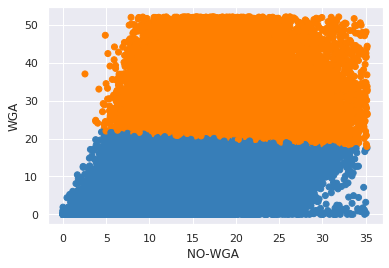

Number of clusters  3
Calinski score:  209592.33089663406
Davies score:  0.8696581710772543


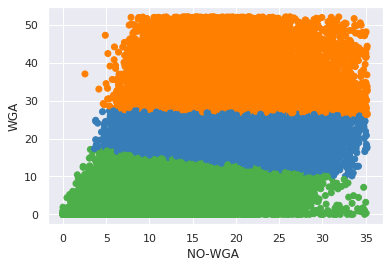

Number of clusters  4
Calinski score:  191994.2264219999
Davies score:  0.9469425656176097


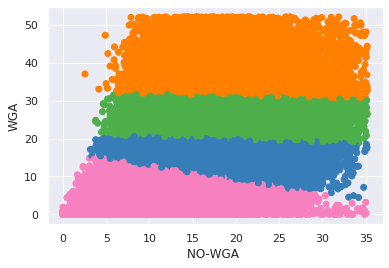

Number of clusters  5
Calinski score:  185151.64945896494
Davies score:  0.89975334300616


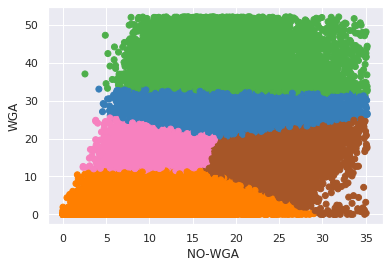

In [27]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)


### GMM Clustering

### ```full```

Number of clusters  2
Converged:  True
BIC:  2440197.407716978


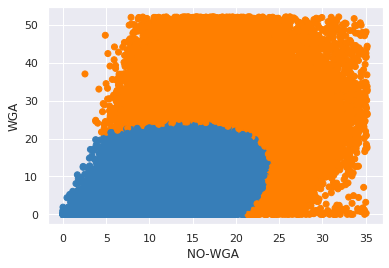

Number of clusters  3
Converged:  True
BIC:  2436173.4910758617


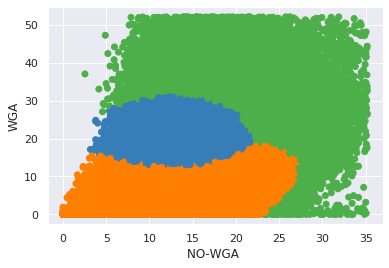

Number of clusters  4
Converged:  True
BIC:  2433670.6434345413


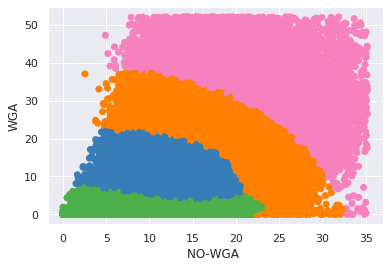

Number of clusters  5


/home/david/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Converged:  False
BIC:  2432231.704828773


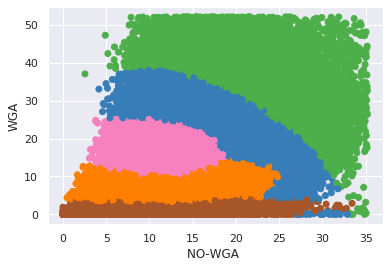

In [32]:
gmm_clustering(clusters=N_CLUSTERS, data=data, 
               tol=1.0e-5, max_itrs=300, n_init=1, 
               cov_type='full',
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)


### ```tied```

Number of clusters  2
Converged:  True
BIC:  2442664.8436123393


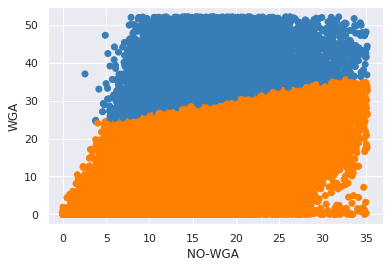

Number of clusters  3
Converged:  True
BIC:  2440314.252264873


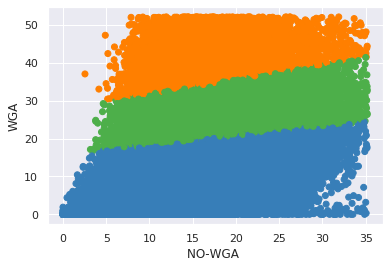

Number of clusters  4
Converged:  True
BIC:  2439169.9960884713


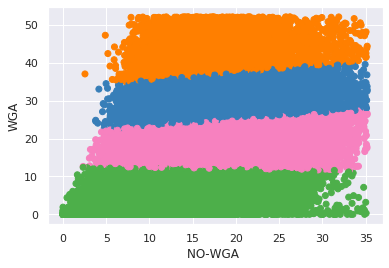

Number of clusters  5
Converged:  True
BIC:  2437644.7184338113


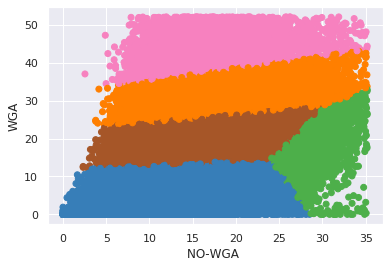

In [33]:
gmm_clustering(clusters=N_CLUSTERS, data=data, 
               tol=1.0e-5, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```diag```

Number of clusters  2
Converged:  True
BIC:  2445707.6695879833


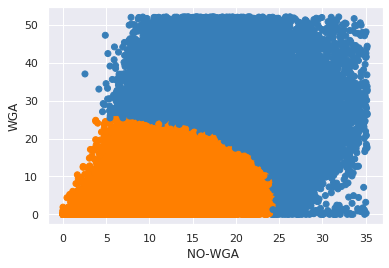

Number of clusters  3
Converged:  True
BIC:  2437319.792547946


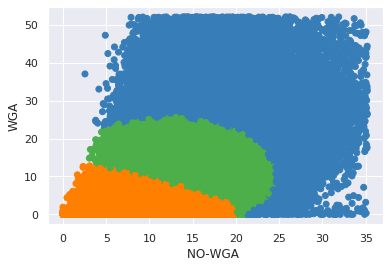

Number of clusters  4
Converged:  True
BIC:  2435192.3937658174


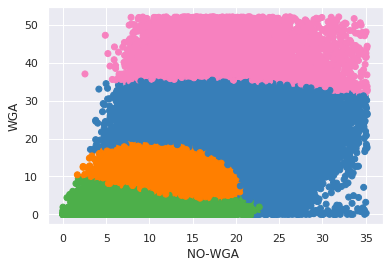

Number of clusters  5
Converged:  True
BIC:  2433076.687972747


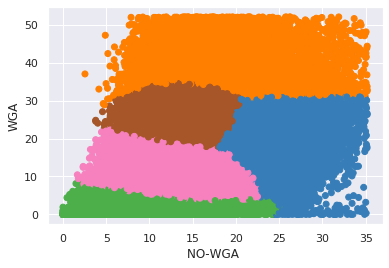

In [34]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```spherical```

Number of clusters  2
Converged:  True
BIC:  2481078.152493678


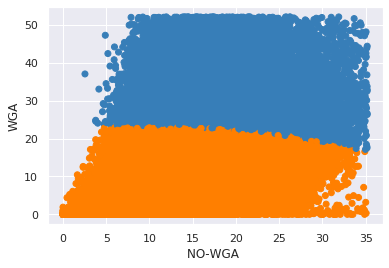

Number of clusters  3
Converged:  True
BIC:  2448787.2904311433


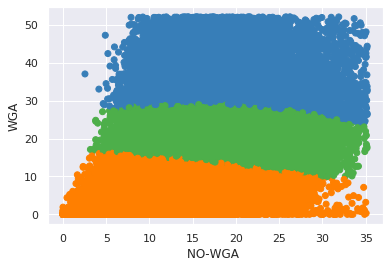

Number of clusters  4
Converged:  True
BIC:  2439605.5769890817


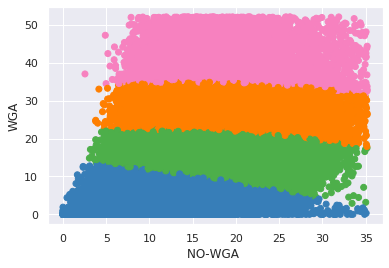

Number of clusters  5
Converged:  True
BIC:  2438222.1583303655


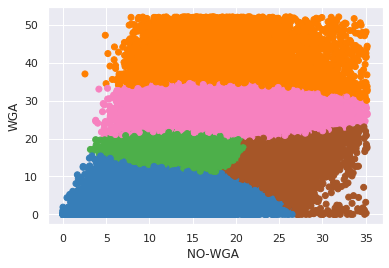

In [35]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## Two means + Ratio

In [36]:

data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

### KMeans

Number of clusters  2
Calinski score:  218080.08478289898
Davies score:  0.7990677116609703


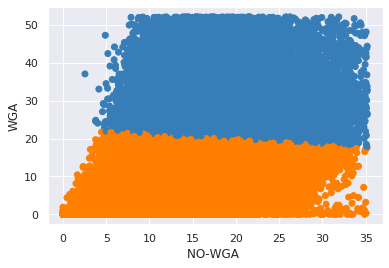

Number of clusters  3
Calinski score:  209088.4353240698
Davies score:  0.8703739006928476


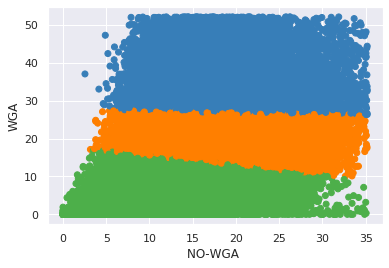

Number of clusters  4
Calinski score:  191412.11349674928
Davies score:  0.948359310979298


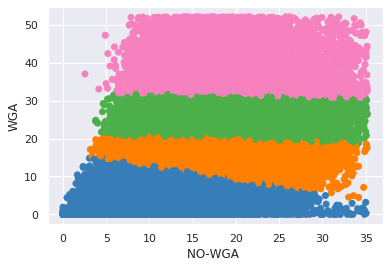

Number of clusters  5
Calinski score:  184575.07027631995
Davies score:  0.897728354187001


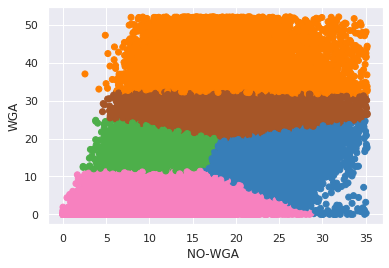

In [37]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### GMM

### ```full```

Number of clusters  2
Converged:  True
BIC:  2112135.4130346724


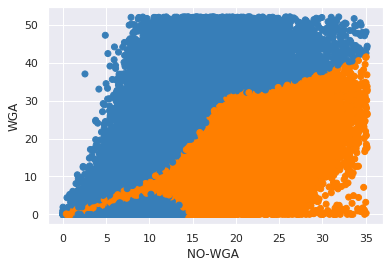

Number of clusters  3
Converged:  True
BIC:  1969278.1131462709


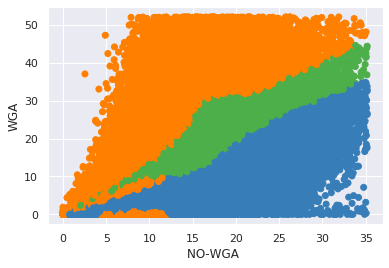

Number of clusters  4
Converged:  True
BIC:  1862295.3289000534


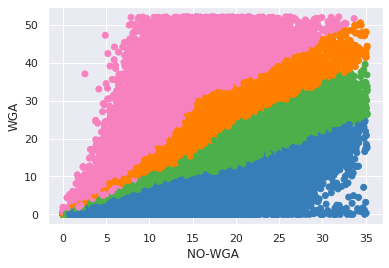

Number of clusters  5
Converged:  True
BIC:  1774424.2911766912


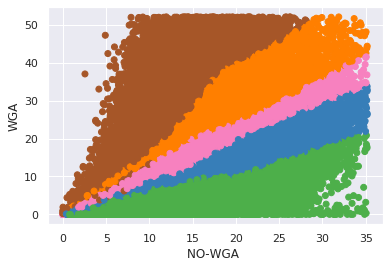

In [42]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```tied```

Number of clusters  2
Converged:  True
BIC:  2323788.936232345


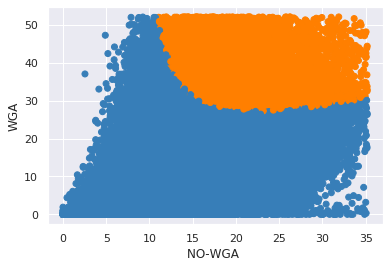

Number of clusters  3
Converged:  True
BIC:  2319610.581411981


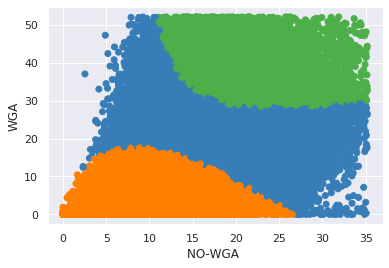

Number of clusters  4
Converged:  True
BIC:  2308238.8220690745


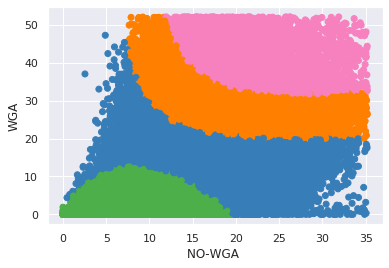

Number of clusters  5
Converged:  True
BIC:  2227533.520506686


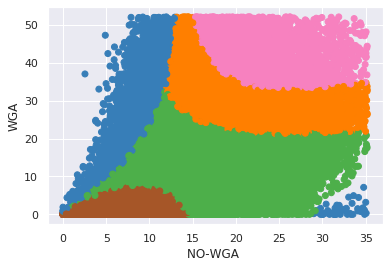

In [41]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-3, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```diag```

Number of clusters  2
Converged:  True
BIC:  2679162.601031963


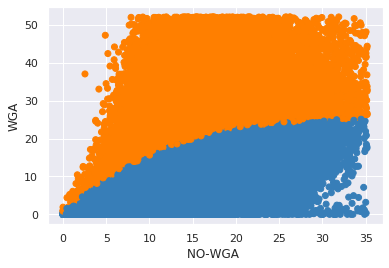

Number of clusters  3
Converged:  True
BIC:  2589259.9224322313


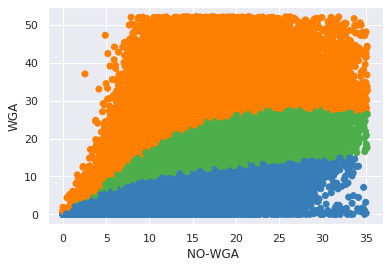

Number of clusters  4
Converged:  True
BIC:  2536687.8746807044


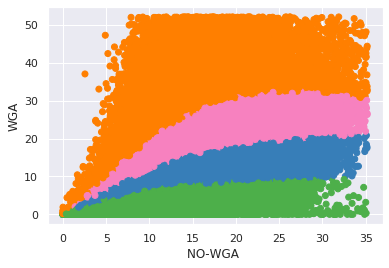

Number of clusters  5
Converged:  True
BIC:  2505871.9322465486


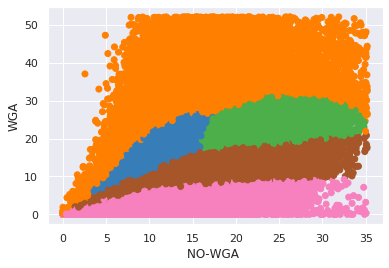

In [40]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```spherical```

Number of clusters  2
Converged:  True
BIC:  3411639.7327101114


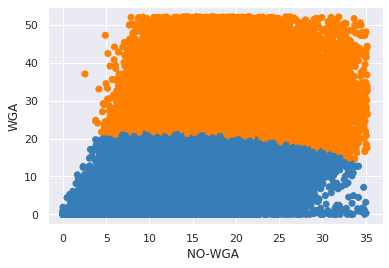

Number of clusters  3
Converged:  True
BIC:  3310744.016380456


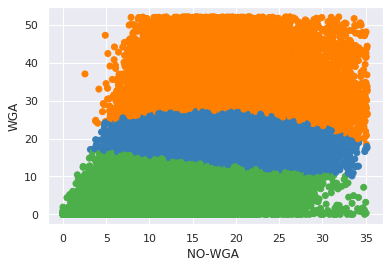

Number of clusters  4
Converged:  True
BIC:  3270437.1586647234


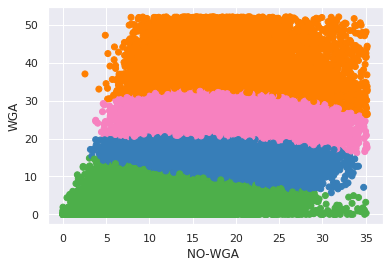

Number of clusters  5
Converged:  True
BIC:  3230759.7154337624


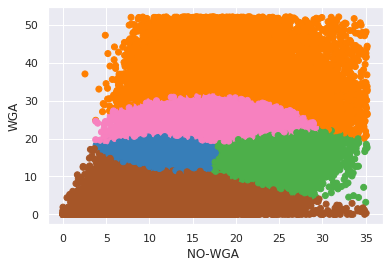

In [38]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='spherical', 
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)